## Hidden Markov Modelling Tutorial

The code used in this script is modified from: https://osl-dynamics.readthedocs.io/en/v1.4.0/tutorials_build/hmm_training_real_data.html

This method takes in preprocessed, source-projected MEG data in the form of a 2-d matrix (sources x time). For each state detected by the algorithm, the spatial pattern and PSD of the state can be computed. 

Note that in this script, we are using the time-delayed embedding version of HMM. 


In [1]:
# Imports 
import numpy as np
import scipy.io as io
import os
import matplotlib.pyplot as plt
import mne
from osl_dynamics.models.hmm import Config, Model
from osl_dynamics.data import Data
from osl_dynamics.utils import plotting
from osl_dynamics.analysis import power

2025-05-16 17:51:40.853810: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 17:51:42.121898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747432302.408582  249374 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747432302.486160  249374 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747432303.250792  249374 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Set file names 
mask_file='T1_template.nii'
parcellation_file="schaefer100_template_volatlas.nii"
data_prefix = 'matrix_scout_schaefer100_template_'

In [15]:
# Read in data - saved as 5 x 60 second chunks
schaefer_data_list = []
for i in range(1,6):
    data_path = data_prefix + str(i) + '.mat'
    curr_dat = io.loadmat(data_path)['Value']
    schaefer_data_list.append(curr_dat)
schaefer_data = np.concatenate(schaefer_data_list,axis=1)

In [17]:
# Configure data in format required by HMM 
data = Data(
    schaefer_data.T,
    n_jobs = 1,
    sampling_frequency=1000,
)

print(data)

Loading files: 100%|██████████| 1/1 [00:00<00:00, 28.55it/s]

Data
 id: 140548011802384
 n_sessions: 1
 n_samples: 300000
 n_channels: 100


### 1. Set Model Parameters

HMM requires the user to begin by setting the embedding size and number of principal components prior to running the model. The TDE and PCA can be computed using the prepare method. From there, the Config method can be used to set the additional hyperparameters of the model. 

The number of HMM states is one important parameter that will greatly affect the output with a larger number of states allowing you to break the data down into more variable patterns. 

For more information on the other parameters of the model, see: https://osl-dynamics.readthedocs.io/en/latest/documentation.html


In [19]:
# set necessary parameters for TDE-HMM 
tde_methods = {
    #"filter": {"low_freq": 15, "high_freq": 30},
    "tde_pca": {"n_embeddings": 15 , "n_pca_components": 80}, # Can change these parameters
    "standardize": {},
}

data.prepare(tde_methods)
print(data)

Calculating PCA components: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]
2025-05-16 17:55:31 INFO osl-dynamics [base.py:852:tde_pca]: Explained variance: 86.4%
Standardize: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]

Data
 id: 140548011802384
 n_sessions: 1
 n_samples: 299972
 n_channels: 80


In [20]:
# Setting hyperparameters of model 
config = Config(
    n_states=6,
    n_channels=data.n_channels,
    sequence_length=1000,
    learn_means=False,
    learn_covariances=True,
    batch_size=16,
    learning_rate=0.001,
    n_epochs=20,
)

In [21]:
# Build model
model = Model(config)
model.summary()

I0000 00:00:1747432536.793967  249374 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6036 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1747432538.907486  249374 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x5575c4c61ad0


Model: "HMM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 1000, 80)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_loss_scalin… │ ()                │          0 │ data[0][0]        │
│ (StaticLossScaling… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ means               │ (6, 80)           │        480 │ data[0][0],       │
│ (VectorsLayer)      │                   │            │ static_loss_scal… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covs                │ (6, 80, 80)       │     19,440 │ data[0][0],       │
│ (CovarianceMatrice… │                   │            │ static_loss_scal… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll                  │ (None, 1000, 80)  │          0 │ data[0][0],       │
│ (SeparateLogLikeli… │                   │            │ means[0][0],      │
│                     │                   │            │ covs[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 1000, 80)  │          0 │ ll[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hid_state_inf       │ [(None, 1000,     │         42 │ cast[0][0]        │
│ (HiddenMarkovState… │ 80), (None, 1000, │            │                   │
│                     │ 6, 6)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 1000, 80)  │          0 │ hid_state_inf[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll_loss             │ (1)               │          0 │ ll[0][0],         │
│ (SumLogLikelihoodL… │                   │            │ cast_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,962 (77.98 KB)

 Trainable params: 19,482 (76.10 KB)

 Non-trainable params: 480 (1.88 KB)

### 2. Initialize Model

Once the model is prepared, it should be initialized by running several iterations of the model to identify optimal initialization weights. This can be done using the random_state_time_course_initialization method or other methods available at: https://osl-dynamics.readthedocs.io/en/latest/documentation.html

In [22]:
# Training
# Initialization
init_history = model.random_state_time_course_initialization(data, n_init=3, n_epochs=1)

2025-05-16 17:55:42 INFO osl-dynamics [inf_mod_base.py:1377:random_state_time_course_initialization]: Random state time course initialization
2025-05-16 17:55:42 INFO osl-dynamics [inf_mod_base.py:1396:random_state_time_course_initialization]: Initialization 0
2025-05-16 17:55:42 INFO osl-dynamics [inf_mod_base.py:1436:set_random_state_time_course_initialization]: Setting random means and covariances
2025-05-16 17:55:43.135486: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1747432544.811276  274384 service.cc:152] XLA service 0x7fd210003600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747432544.811291  274384 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-05-16 17:55:45.085209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `ML

 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - ll_loss: 115.7209 - loss: 115.7209

2025-05-16 17:55:46.838983: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1747432546.849334  274384 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - ll_loss: 112.8569 - loss: 112.8569 - learning_rate: 0.0010 - rho: 0.2853


2025-05-16 17:55:49 INFO osl-dynamics [inf_mod_base.py:1396:random_state_time_course_initialization]: Initialization 1
2025-05-16 17:55:49 INFO osl-dynamics [inf_mod_base.py:1436:set_random_state_time_course_initialization]: Setting random means and covariances
2025-05-16 17:55:49.395606: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 1/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - ll_loss: 112.6612 - loss: 112.6611

2025-05-16 17:55:51.486605: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 16 bytes spill stores, 16 bytes spill loads



18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - ll_loss: 112.4063 - loss: 112.4063 - learning_rate: 0.0010 - rho: 0.2853


2025-05-16 17:55:53 INFO osl-dynamics [inf_mod_base.py:1396:random_state_time_course_initialization]: Initialization 2
2025-05-16 17:55:53 INFO osl-dynamics [inf_mod_base.py:1436:set_random_state_time_course_initialization]: Setting random means and covariances


 1/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - ll_loss: 119.7374 - loss: 119.7374

2025-05-16 17:55:56.053623: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 16 bytes spill stores, 16 bytes spill loads



18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - ll_loss: 113.9006 - loss: 113.9006 - learning_rate: 0.0010 - rho: 0.2853


2025-05-16 17:55:58 INFO osl-dynamics [inf_mod_base.py:1422:random_state_time_course_initialization]: Using initialization 1


### 3. Train Model

After preparing and initializing the model, it can now be fit to your data using the fit function in the osl_dynamics package.

In [23]:
# Full training
history = model.fit(data)

Epoch 1/20
 1/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - ll_loss: 111.1840 - loss: 111.1840

2025-05-16 17:56:12.420667: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 16 bytes spill stores, 16 bytes spill loads



18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - ll_loss: 112.1825 - loss: 112.1826 - learning_rate: 0.0010 - rho: 0.2853
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - ll_loss: 111.4866 - loss: 111.4866 - learning_rate: 9.0484e-04 - rho: 0.1866
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - ll_loss: 111.5656 - loss: 111.5656 - learning_rate: 8.1873e-04 - rho: 0.1436
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - ll_loss: 110.9238 - loss: 110.9238 - learning_rate: 7.4082e-04 - rho: 0.1187
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - ll_loss: 110.2345 - loss: 110.2345 - learning_rate: 6.7032e-04 - rho: 0.1022
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - ll_loss: 110.7570 - loss: 110.7570 - learning_rate: 6.0653e-04 - rho: 0.0904
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - ll_loss: 110.0346 - loss: 110.0346 - learning_rate: 5.4881e-04 - rho: 0.0814
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - ll_loss: 111.2790 - loss: 111.2790 - learnin

### Extract Power Spectra and Power Maps 

Once the HMM has been trained, the user can extract the state probabilities from the model and use them to index the original data to derive power spectral measures for each state. The power of the states in each anatomical region can also be plotted on the brain by loading in niftii files of anatomical MRI and atlas used to parcellate the data. 

In [24]:
# Inferred state probabilities
alpha = model.get_alpha(data)

2025-05-16 17:58:26 INFO osl-dynamics [inf_mod_base.py:1115:get_alpha]: Getting alpha


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step


In [26]:
# Reload original data because it has been modified
og_data = Data(schaefer_data.T, n_jobs = 1, sampling_frequency=1000)
print(og_data)

Loading files: 100%|██████████| 1/1 [00:00<00:00, 41.59it/s]

Data
 id: 140546996644320
 n_sessions: 1
 n_samples: 300000
 n_channels: 100


In [27]:
# trim data to match tde data
trimmed_data = og_data.trim_time_series(n_embeddings=15, sequence_length=1000)

# make sure 1st dimension matches => trimmed data is correct length
print(alpha.shape, trimmed_data.shape)

(299000, 6) (299000, 100)


In [28]:
# calculating state spectra & coherence 

# Welch 
from osl_dynamics.analysis import spectral
f, psd, coh, w = spectral.welch_spectra(
    data=trimmed_data,
    alpha = alpha,
    sampling_frequency =1000,
    frequency_range=[1,50],
    return_weights = True,
    n_jobs=1,
)

2025-05-16 17:58:43 INFO osl-dynamics [spectral.py:244:welch_spectra]: Calculating spectra


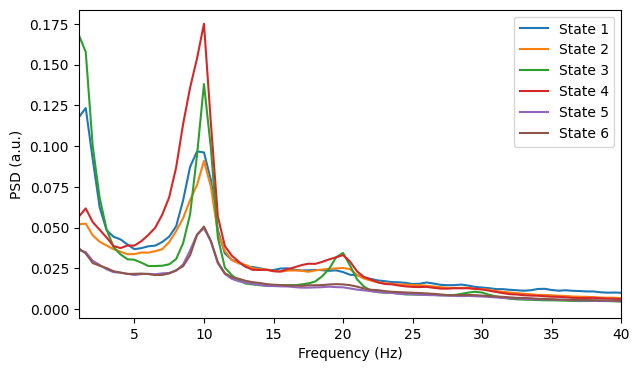

In [29]:
# Plot PSDs 
av_psd = np.mean(psd, axis=1) # average PSD over channels

n_states = av_psd.shape[0]
fig, ax = plotting.plot_line(
    [f] * n_states,
    av_psd,
    labels=[f"State {i}" for i in range(1, n_states + 1)],
    x_label="Frequency (Hz)",
    y_label="PSD (a.u.)",
    x_range=[1, 40]
)

(6, 100)


/export03/data/lindseyp/beta_burst_language/py3env/lib/python3.10/site-packages/nilearn/image/image.py:1666: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(
Saving images: 100%|██████████| 6/6 [00:01<00:00,  4.18it/s]


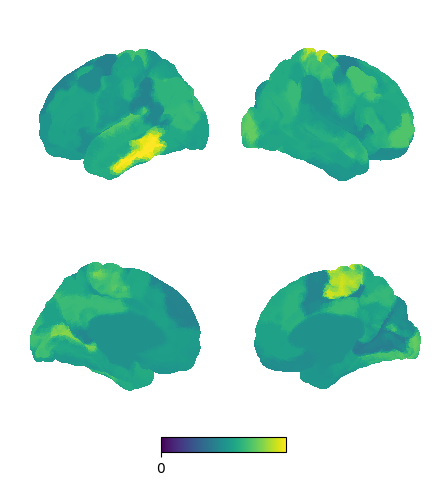

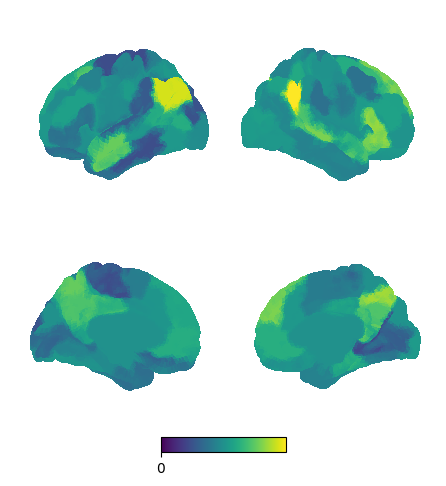

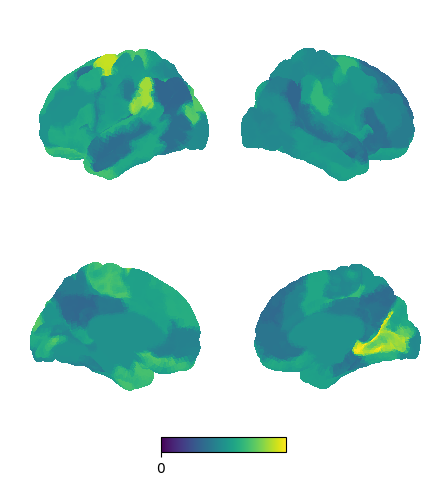

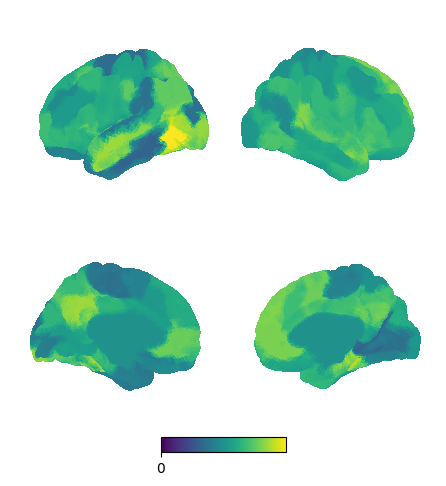

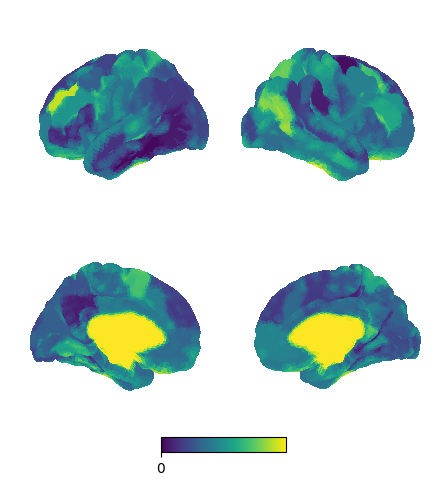

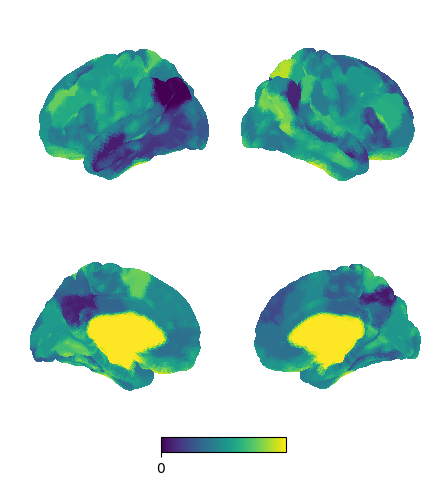

In [30]:
## Plot anatomical networks 
p = power.variance_from_spectra(f, psd)
print(p.shape) # power maps 

fig, ax = power.save(
    p,
    mask_file=mask_file,
    parcellation_file=parcellation_file,
    plot_kwargs={"cmap": 'viridis'},
    subtract_mean=True
)